In [1]:
import os
os.chdir('/Users/lilimatic/np_var_mis')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from functions import *

from scipy.optimize import minimize
from multiprocess import Pool

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
df = pd.read_csv('mcycle.csv')

In [4]:
df.columns = ['x','y']

In [5]:
df = df.sort_values(by=['y'])

In [6]:
y = df.y
X = df.x

#b0=1, b1=1 90 % obs 
#b0=0, b=1 85 %
#b=0.7,0.7
b0 = -0.5
b1 = -0.5

In [7]:
n = len(df)
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

In [8]:
size = round(sum(omega)/len(df)*100,0)

In [9]:
size

39.0

In [10]:
df['omega'] = omega

In [11]:
df_cc = df[df.omega==1]

In [12]:
df_cc.min()

x          2.6
y       -123.1
omega      1.0
dtype: float64

In [13]:
model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')


In [14]:
model.bw

array([0.91384625])

In [15]:
def r_parallel(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return df.omega[j]*(df.y[j]-y_hat)**2

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [16]:
%%time
# r_parallel(0.1)
h_ipw = minimize(r_parallel, 0.9).x

CPU times: user 2.74 s, sys: 517 ms, total: 3.26 s
Wall time: 3.35 s


In [17]:
h_ipw[0]

1.1249834062985802

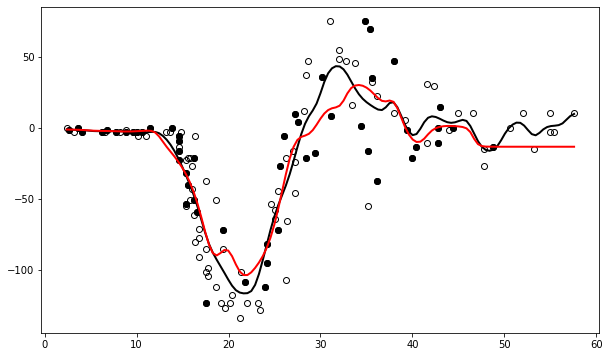

In [18]:
fig, ax = plt.subplots(1, 1,figsize=(10, 6))

plt.plot(df['x'],df['y'],'o',mfc='none',color='black')
plt.plot(df_cc['x'],df_cc['y'],'o',color='black')


#Full model 
ax.plot(np.linspace(2.4, 57.6, n),model.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'black', lw=2)

#CC estimator 
#ax.plot(np.linspace(2.4, 57.6, n),model_cc.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'blue', lw=2)

#IPW estimator 
ax.plot(np.linspace(2.4, 57.6, n),[nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(2.4, 57.6, n)],color= 'red', lw=2)

plt.savefig(f'Mcyle_{size}.pdf',transparent=True)

In [19]:
df['res_sqr'] = (df.y -  model.fit(df.x)[0])**2

df['res_abs'] = np.abs(df.y -  model.fit(df.x)[0])

df_cc['res_abs'] = np.abs(df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega)))

df_cc['res_sqr'] =(df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega)))**2


<ipython-input-19-49071ffb8f92>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['res_abs'] = np.abs(df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega)))
<ipython-input-19-49071ffb8f92>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['res_sqr'] =(df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega)))**2


In [20]:
np.mean(df_cc['res_abs']) / np.mean(df['res_abs'])

0.8831048021845909

In [21]:
np.mean(df_cc['res_sqr']) / np.mean(df['res_sqr'])

0.9000842728185632

In [22]:
np.mean(df['res_sqr'])

444.4740488799977

In [23]:
np.mean(df_cc['res_sqr'])

400.06410107287525

In [24]:
#df_cc['res_ipw'] = df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw_ipw,t,X,y,pi(y,b0,b1),omega))


In [25]:
np.mean(df_cc['res_sqr'])/np.mean(df['res_sqr'])

0.9000842728185632

In [26]:

#model_var_cc = KernelReg(endog=[df_cc.res_sqr],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')

#Direct method 
#h_fix = 1.5

#model_dir_vn = KernelReg(endog=[(df.y)**2],exog=[df.x],reg_type='lc',var_type='c', bw='{h}') 
#model_dir_mn = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='{h}') 

#Differences 

#Residual

#model_dir_mn = KernelReg(endog=[df_diff.y],exog=[df_diff.x],reg_type='lc',var_type='c', bw='{h}') 

In [27]:
#Full residual-based
model_var = KernelReg(endog=[df.res_sqr],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')


/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)


In [28]:
df['res'] = (df['y'] - model.fit(df['x'])[0])**2
df_cc['res'] = (df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega)))**2

<ipython-input-28-31add71344ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['res'] = (df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw,t,X,y,pi(y,b0,b1),omega)))**2


In [29]:
model_res = KernelReg(endog=[df.res],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')


/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)


In [30]:
def nw_mis(h,x,X,y,p,omega):
    #if h < 0.001:
    #    h = 0.001
    y = ((y*omega)/p)
    num = sum(y*norm.pdf((x-X)/h))
    dem = sum((omega/p)*norm.pdf((x-X)/h))
    return num/dem

In [31]:
df_cc.reset_index(inplace=True)

In [32]:
# Create a DataFrame using the array
df_ones = pd.DataFrame(np.ones(df_cc[['x']].shape))

def r_parallel_res(h):
    #print(1)
    def fn(j):
        df1 = df_cc.drop([j],axis=0)
        df_ones1 = df_ones.drop([j],axis=0)
        y_hat = nw_mis(h,df_cc.x[j],df1.x,df1.res,pi(df1.y,b0,b1),df_ones1[0])
        return (df_cc.res[j]-y_hat)**2 

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df_cc))))

In [33]:
h_ipw_var = minimize(r_parallel_res, 0.6).x

h_ipw_var

array([1.86833653])

<ipython-input-34-5c4f1ce7fc6c>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-g" (-> color='g'). The keyword argument will take precedence.
  ax.plot(np.linspace(2.4, 57.6, n),[sigma_mis_res(h_ipw_var,t,df_cc.x,df_cc.res,pi(df_cc.y,b0,b1),df_ones[0])**2 for t in np.linspace(2.4, 57.6, n)],'-g',color= 'red', lw=2)


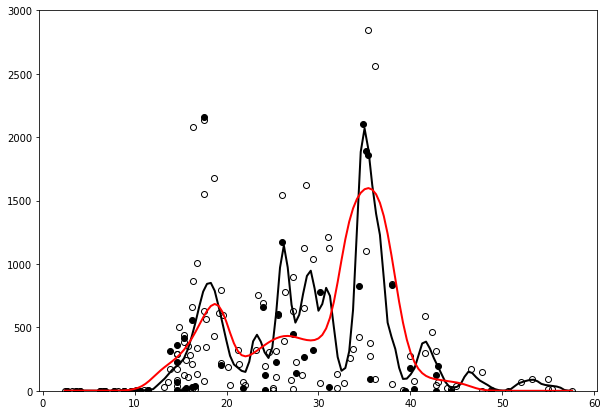

In [34]:
fig, ax = plt.subplots(1, 1,figsize=(10, 7))

plt.plot(df['x'],df['res'],'o',mfc='none',color='black')

plt.plot(df_cc['x'],df_cc['res'],'o',color='black')



#Full
ax.plot(np.linspace(2.4, 57.6, n),model_res.fit(np.linspace(2.4, 57.6, n))[0] ,color= 'black', lw=2)

#IPW
ax.plot(np.linspace(2.4, 57.6, n),[sigma_mis_res(h_ipw_var,t,df_cc.x,df_cc.res,pi(df_cc.y,b0,b1),df_ones[0])**2 for t in np.linspace(2.4, 57.6, n)],'-g',color= 'red', lw=2)

ax.set_ylim(0,3000)

plt.savefig(f'figures/Residual_Real_MCycle_{size}.pdf',transparent=True)


In [35]:
model_var.bw

array([0.60511441])

In [36]:
h_ipw_var

array([1.86833653])